[View in Colaboratory](https://colab.research.google.com/github/steineron/TensowFlowFirstSteps/blob/master/intro_to_neural_nets.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Neural Networks

**Learning Objectives:**
  * Define a neural network (NN) and its hidden layers using the TensorFlow `DNNRegressor` class
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

## Setup

First, let's load and prepare the data.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [0]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2651.6,539.7,1430.4,501.9,3.9,2.0
std,2.1,2.0,12.6,2224.2,430.0,1179.2,392.9,1.9,1.1
min,32.5,-124.3,1.0,11.0,3.0,3.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1458.0,295.0,785.0,280.0,2.6,1.5
50%,34.3,-118.5,29.0,2126.5,433.0,1164.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3156.2,646.0,1723.2,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2624.6,538.8,1427.7,499.5,3.9,2.0
std,2.1,2.0,12.5,2070.0,400.4,1068.9,363.5,1.9,1.3
min,32.5,-124.3,2.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.8,300.0,799.0,284.0,2.6,1.5
50%,34.2,-118.5,28.0,2129.5,435.0,1175.0,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3139.5,656.0,1715.0,609.0,4.7,2.3
max,41.9,-114.6,52.0,28258.0,4183.0,15037.0,4072.0,15.0,41.3


Training targets summary:


,median_house_value
count,12000.0
mean,207.7
std,116.2
min,15.0
25%,119.8
50%,180.9
75%,265.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.4
std,115.4
min,15.0
25%,119.1
50%,178.6
75%,262.5
max,500.0


## Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # features: <class 'pandas.core.frame.DataFrame'> 
    # targets: <class 'pandas.core.series.Series'>

    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    # on the training input
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    #on the validation input
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


Training model...
RMSE (on training data):
  period 00 : 186.26
  period 01 : 155.09
  period 02 : 318.94
  period 03 : 153.90
  period 04 : 157.43
  period 05 : 145.24
  period 06 : 154.93
  period 07 : 141.27
  period 08 : 175.19
  period 09 : 121.62
Model training finished.
Final RMSE (on training data):   121.62
Final RMSE (on validation data): 120.43


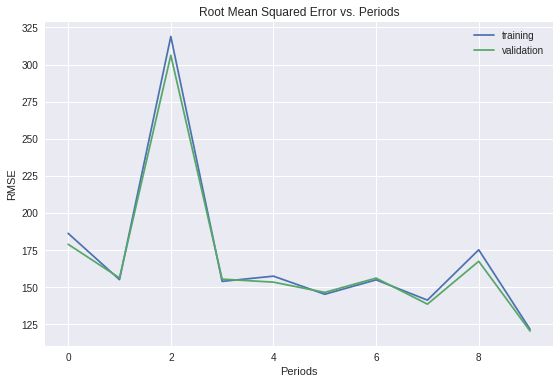

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

looks like hte models didn't overfit - but loss was ~215, and not 110 as required.

Another attempt, this time using more neurons in the second layer

Training model...
RMSE (on training data):
  period 00 : 144.58
  period 01 : 138.26
  period 02 : 152.45
  period 03 : 157.46
  period 04 : 138.08
  period 05 : 171.28
  period 06 : 125.98
  period 07 : 157.13
  period 08 : 194.27
  period 09 : 131.16
Model training finished.
Final RMSE (on training data):   131.16
Final RMSE (on validation data): 133.36


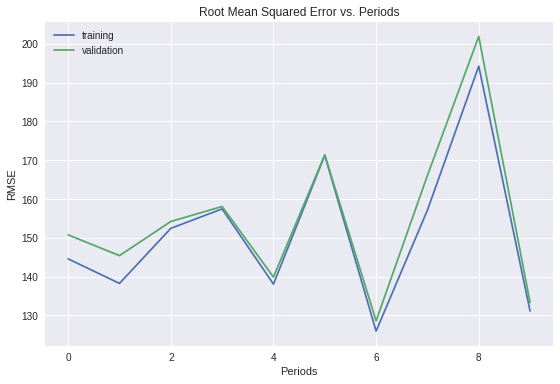

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

more neurons - [10,10]  produce a better loss (130) and no sign of overfitting.
however - **the loss plot became very juggy**, and different in both executions... is that fine?

trying again with same LR, layers but more steps (800):

Training model...
RMSE (on training data):
  period 00 : 177.49
  period 01 : 226.48
  period 02 : 198.12
  period 03 : 149.37
  period 04 : 177.42
  period 05 : 134.57
  period 06 : 132.60
  period 07 : 180.05
  period 08 : 135.51
  period 09 : 186.65
Model training finished.
Final RMSE (on training data):   186.65
Final RMSE (on validation data): 191.09


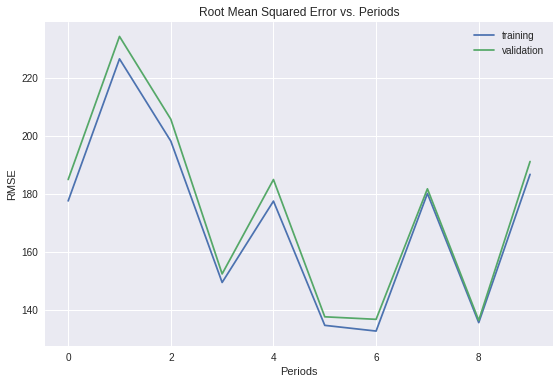

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=800,
    batch_size=10,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

more steps result executions: 

1.   the loss on training and validation hasn't changed much but seems more tight than before....
2.   same
3.   juggy loss, landed on 190 - no good


Next attempt: leaving the steps on 800, and adding a 3rd layer of 10 neurons:


Training model...
RMSE (on training data):
  period 00 : 207.13
  period 01 : 167.25
  period 02 : 223.25
  period 03 : 159.69
  period 04 : 241.24
  period 05 : 154.37
  period 06 : 198.91
  period 07 : 147.35
  period 08 : 137.56
  period 09 : 206.09
Model training finished.
Final RMSE (on training data):   206.09
Final RMSE (on validation data): 214.04


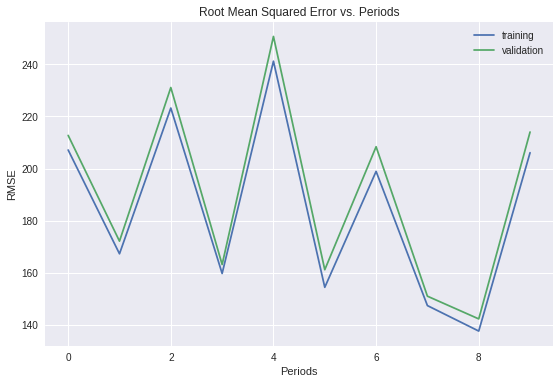

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=800,
    batch_size=10,
    hidden_units=[10, 10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

executions:


1.   Loss dropped below 120
2.   loss ~120, but just a little less tight than before. trying again
3.   Loss is at 145~ - not that good :(
4.   Juggy loss - landed on 220 :(



The only thing that seems consistent is the increasing the # of steps produces tighter loss on validation and training samples.


Next - **reducing the number of neurons** in each layers:

leaving 3 layers but dropping hte nuber of neurons to 5 in each

Training model...
RMSE (on training data):
  period 00 : 233.93
  period 01 : 230.46
  period 02 : 227.03
  period 03 : 223.60
  period 04 : 220.19
  period 05 : 216.79
  period 06 : 213.43
  period 07 : 210.08
  period 08 : 206.80
  period 09 : 203.50
Model training finished.
Final RMSE (on training data):   203.50
Final RMSE (on validation data): 205.13


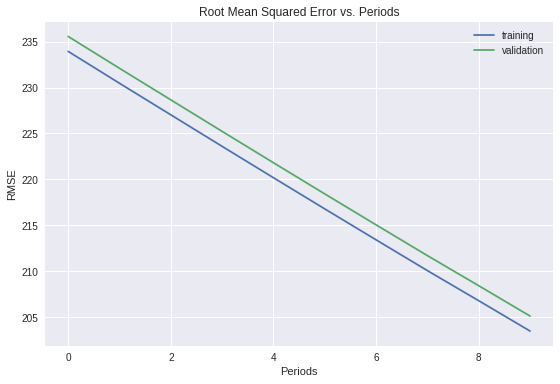

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=800,
    batch_size=10,
    hidden_units=[5, 5, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

First impression - good - the **curve is smoother** and loss is at 125~

second impression - smooth curve but loss is too hight ~200

third - same as second

 **Interestingly - the total number of neurons is roughly the same as the first execution - [10,2] and [5,5,5]**
 
 Next - keeping the same totoal number of neurons but adding a **4th** layer

Training model...
RMSE (on training data):
  period 00 : 244.46
  period 01 : 169.98
  period 02 : 168.74
  period 03 : 188.23
  period 04 : 171.74
  period 05 : 163.50
  period 06 : 160.97
  period 07 : 233.06
  period 08 : 158.84
  period 09 : 186.85
Model training finished.
Final RMSE (on training data):   186.85
Final RMSE (on validation data): 192.96


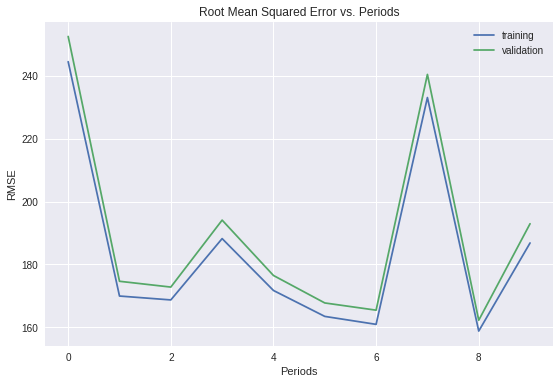

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=800,
    batch_size=10,
    hidden_units=[4, 4, 4, 4],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

First impression for 4th layer X 16 neurons - loss is at 125~, curve is a bit more juggy. waiting for the second....

Second - **not so good** as curve seems juggy and loss landed on 190~

Next - trying 12 neurons in 4 layers

Training model...
RMSE (on training data):
  period 00 : 233.71
  period 01 : 230.24
  period 02 : 226.79
  period 03 : 223.36
  period 04 : 219.95
  period 05 : 216.56
  period 06 : 213.19
  period 07 : 209.84
  period 08 : 206.51
  period 09 : 203.21
Model training finished.
Final RMSE (on training data):   203.21
Final RMSE (on validation data): 204.84


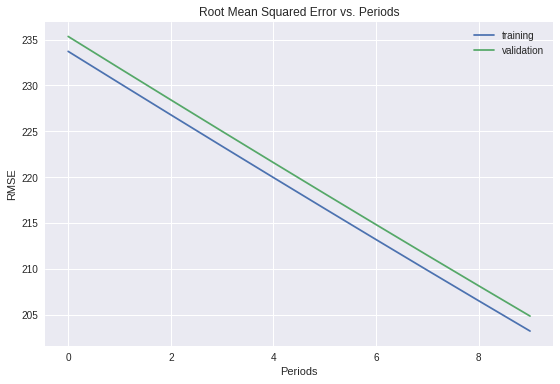

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=800,
    batch_size=10,
    hidden_units=[3,3,3,3],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

first impression - **smooth decreasing loss, but high**, 200~. 

is 12 the magic number of neurons?

interesting second result - curve is decreasing, loss is 120~

third attempt - loss land at 200 but the curve is smooth nad decreasing.

Next - trying more steps with 3x4 setup:

Training model...
RMSE (on training data):
  period 00 : 233.05
  period 01 : 223.63
  period 02 : 191.74
  period 03 : 128.83
  period 04 : 120.51
  period 05 : 118.34
  period 06 : 117.10
  period 07 : 116.67
  period 08 : 116.42
  period 09 : 116.68
Model training finished.
Final RMSE (on training data):   116.68
Final RMSE (on validation data): 117.96


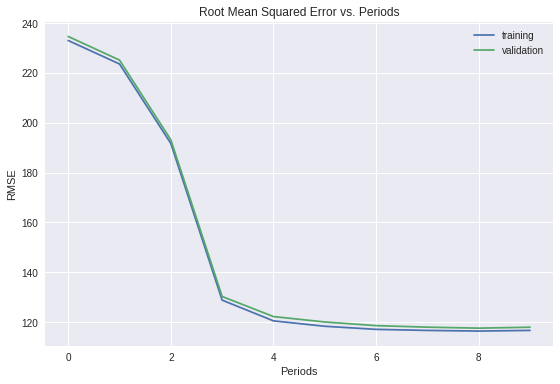

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=5000,
    batch_size=10,
    hidden_units=[3,3,3,3],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

just increasing the number of steps to 1600  seem to mess it up.... (is this where early stopping plays a role?)

**interestingly** keeping the 12 neurons and the LR-to-steps ratio seems to keep the loss curve at bay, i.e. smooth and decreasing

LR = 0.001, steps = 5000 and 3,3,3,3 NN decrease the loss in a smooth curve to below 120.

**so far - it seems that more layers require more steps and smaller LR**

tried a similar setup with 4,4,2,2 and 6,6 - was not improving...

interestingly - larger batch size - 100 - creates a less juggy curve?

next - reduced the LR to 0.000**3** and tripled the steps to **15**000 ina **3,3,3,3** NN

next - reduced the LR to 0.000**1** and tripled the steps to **50**000 ina **4,4,4,4** NN

at this point the loss droped to 105~, the curve was steadily dropping. that's **GOOD**

next - added a **5th layer**... it trains slower, and the drop is small, at first! the last 2 periods demonstrated a stiffer slop.

next adding more steps (70000)

the one thing that proved a good chice was increasing the batch size - it added stability - the loss-curve isn't as juggy.

70000 steps was not producing a better loss with a 4,4,4,4,4 NN, tho it started with a 200+ loss and dropped well from there. **is the NN initialisation the cause**?

a second attempt was somewhat better.... but again - couldn't land it lower than 105~

trying a different NN setups:

5,5,5,5 - two attempts, one was a bit better.... 

8,8,8,8 - two attempts both were **better** - stablising on **97+**, very tight training and validation losses

10,10,10,10 one execution perform slightly better - reducing loss to 94.

Other combinations, such as 5 or 6 layers, more neuron did not drop the loss much further.



Training model...
RMSE (on training data):
  period 00 : 159.88
  period 01 : 143.18
  period 02 : 107.95
  period 03 : 100.39
  period 04 : 99.09
  period 05 : 98.72
  period 06 : 98.31
  period 07 : 98.13
  period 08 : 97.81
  period 09 : 97.70
Model training finished.
Final RMSE (on training data):   97.70
Final RMSE (on validation data): 98.23


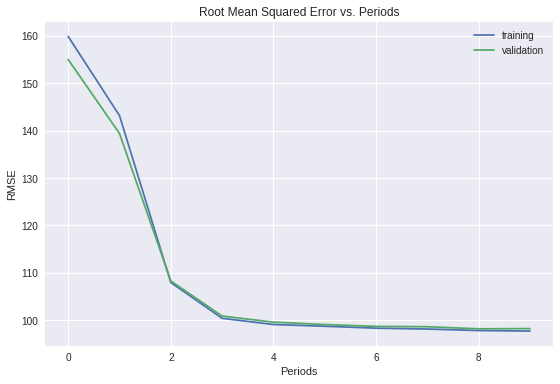

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.0001,
    steps=50000,
    batch_size=100,
    hidden_units=[10,10,10,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below to see a possible solution

**NOTE:** This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective. This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 146.08
  period 01 : 141.81
  period 02 : 134.08
  period 03 : 125.51
  period 04 : 116.94
  period 05 : 113.06
  period 06 : 112.50
  period 07 : 105.53
  period 08 : 104.44
  period 09 : 106.10
Model training finished.
Final RMSE (on training data):   106.10
Final RMSE (on validation data): 107.62


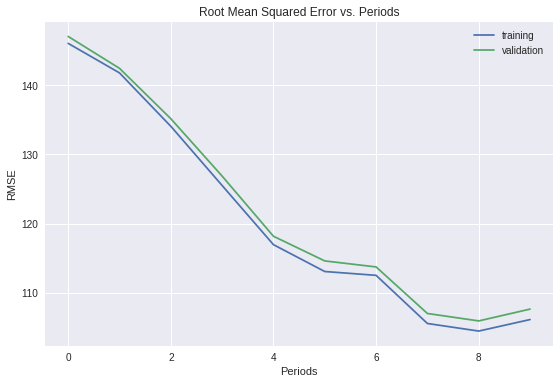

In [0]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv).

In [0]:
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

# build the features from the data
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)


predict_validation_input_fn = lambda: my_input_fn(test_examples, 
                                                  test_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                    shuffle=False)
# Train the model, but do so inside a loop so that we can periodically assess
# loss metrics.
print("Predictin with test data...")
training_rmse = []
validation_rmse = []
# Take a break and compute predictions.
#on the validation input
validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
# Compute **predictions** and **test** loss.
validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, test_targets))
# Occasionally print the current loss.
print("RMSE (on training data: %0.2f" % (validation_root_mean_squared_error))
  

Predictin with test data...
RMSE (on training data: 96.99


### Solution

Click below to see a possible solution.

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [0]:
california_housing_test_data = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["median_house_value"], 
                                               num_epochs=1, 
                                               shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 96.99
